#Training and Evaluating Xception Model

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras import models
from keras import layers
import keras as ks
from keras import Input
from keras import utils
from keras import losses
from keras import optimizers
from keras import metrics
from tensorflow.keras.preprocessing import image as preprocessing_image
from keras import applications
from keras import callbacks

#Load Pre-Trained Xception Model

In [6]:
lrn_rate=0.001
epoch = 30
batch_siz= 128

In [8]:
BASE_DIR = "D:/inceptionv3/Dataset"

# preprossecing and ahumantation
train_datagen = preprocessing_image.ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen= preprocessing_image.ImageDataGenerator(horizontal_flip=True)

# Get Images form the dir
train_generator = train_datagen.flow_from_directory(os.path.join(BASE_DIR, "train"), target_size=(150,150), batch_size=batch_siz, class_mode='categorical')
test_set = test_datagen.flow_from_directory(os.path.join(BASE_DIR, "test"), target_size=(299,299), batch_size=batch_siz, class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(os.path.join(BASE_DIR, "val"), target_size=(150,150), batch_size=batch_siz, class_mode='categorical')


Found 16979 images belonging to 32 classes.
Found 3630 images belonging to 32 classes.
Found 3636 images belonging to 32 classes.


In [20]:
# Number of classes in the output layer
class_number = len(validation_generator.class_indices.keys())
class_number


32

In [21]:
# load pre-trained Xception model and exclude top dense layer
base_model = applications.InceptionV3(include_top=False,
                                   weights='imagenet',
                                   input_shape=(150,150,3))


In [22]:
print("Model input shape: {}\n".format(base_model.input_shape))
print("Model output shape: {}\n".format(base_model.output_shape))
print("Model number of layers: {}\n".format(len(base_model.layers)))

Model input shape: (None, 150, 150, 3)

Model output shape: (None, 3, 3, 2048)

Model number of layers: 311



#Fine-tune Xception Model

In [23]:
base_model.trainable = False

In [24]:
def fine_tune_Inception(base_model):

    inputs = Input(shape=(150,150, 3))

    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    # final Dense layer
    outputs = layers.Dense(class_number, activation='softmax')(x)

    # define model with base_model's input
    model = models.Model(inputs=inputs, outputs=outputs)

   

    return model




#Compile Model

In [25]:
# Compile model
def compile_model(model):
    
    loss = losses.categorical_crossentropy

    # optimizer
    optimizer = optimizers.Adam(learning_rate=lrn_rate)

    # metrics
    metric= [metrics.categorical_accuracy]

    model.compile(optimizer=optimizer, loss=loss, metrics=metric)  # Remove metrics=metrics
    
    return model


In [26]:
model = fine_tune_Inception(base_model)
model = compile_model(model)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        65,568 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,868,352 (83.42 MB)

 Trainable params: 65,568 (256.12 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

#Image Preprocessing And Augmentation

#Train Model on Custome Dataset

In [27]:
print("Model input shape: {}\n".format(model.input_shape))
print("Model output shape: {}\n".format(model.output_shape))
print("Model number of layers: {}\n".format(len(model.layers)))

Model input shape: (None, 150, 150, 3)

Model output shape: (None, 32)

Model number of layers: 4



In [28]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [29]:
history = model.fit(
    train_generator,
    epochs=epoch,
    callbacks=[early_stopping],
    validation_data = validation_generator
    )

Epoch 1/30


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step - categorical_accuracy: 0.5548 - loss: 1.7176 - val_categorical_accuracy: 0.9018 - val_loss: 0.3938
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - categorical_accuracy: 0.9126 - loss: 0.3466 - val_categorical_accuracy: 0.9359 - val_loss: 0.2529
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - categorical_accuracy: 0.9421 - loss: 0.2280 - val_categorical_accuracy: 0.9483 - val_loss: 0.1958
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - categorical_accuracy: 0.9556 - loss: 0.1781 - val_categorical_accuracy: 0.9505 - val_loss: 0.1838
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - categorical_accuracy: 0.9591 - loss: 0.1534 - val_categorical_accuracy: 0.9620 - val_loss: 0.1502
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - categorical_accuracy: 0.9721 - loss: 0.1224 - val_categorical_accuracy: 0.9706 - val_loss: 0.1232
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - categorical_accuracy: 0.9685 - loss: 0

#Plot Accuracy And Loss Over Time

In [2]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

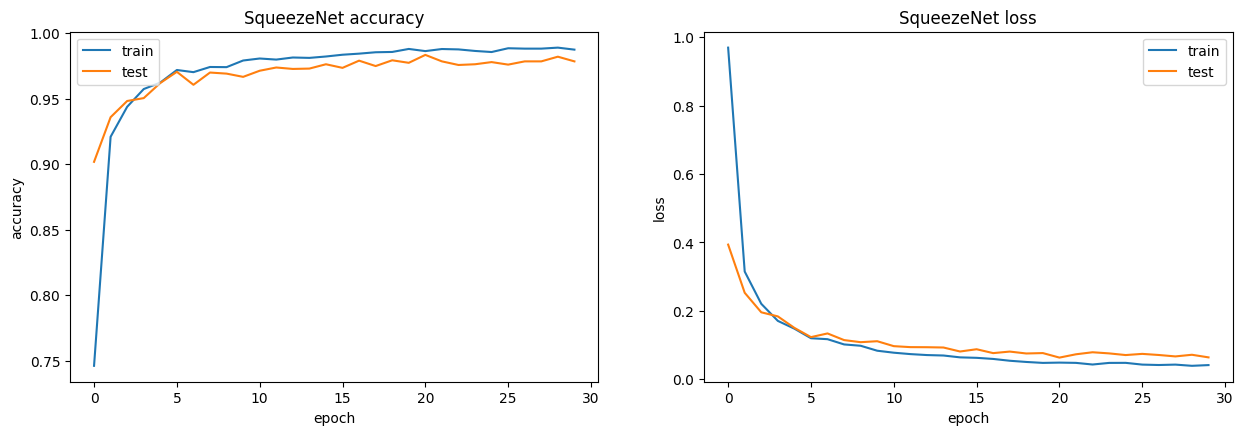

In [31]:
plot_accuracy_and_loss(history)

In [33]:
# save model architecture
model_json = model.to_json()
open('Inception_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_xception.weights.h5', overwrite=True)

In [14]:
model.evaluate(train_generator)

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - categorical_accuracy: 0.9893 - loss: 0.0401


[0.041782572865486145, 0.9887508153915405]

#Save Model Weights And Configuration

In [15]:
model.evaluate(validation_generator)

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - categorical_accuracy: 0.9834 - loss: 0.0613


[0.07368828356266022, 0.9777227640151978]